In [32]:
%pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("List of GPU devices:")
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
List of GPU devices:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [61]:
import cv2
import numpy as np
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, Precision, Recall
import tensorflow.keras.backend as K # Importer le backend de Keras
import shutil
import matplotlib.pyplot as plt


# Dataprocess

In [77]:
import os
from PIL import Image
import numpy as np
import random
import shutil  # Import the shutil module


# --- Définition des dossiers ---
resized_frames_dir = 'datas/frames_resized'
resized_masks_dir = 'datas/masks_resized'

norm_frames_dir = 'datas/frames_norm'
norm_masks_dir = 'datas/masks_norm'


# --- Création des dossiers de sortie ---
os.makedirs(norm_frames_dir, exist_ok=True)
os.makedirs(norm_masks_dir, exist_ok=True)


# --- Normalisation des images frames redimensionnées et sauvegarde au format .npy ---
resized_image_filenames = os.listdir(resized_frames_dir)
for image_file in resized_image_filenames:
    resized_image_path = os.path.join(resized_frames_dir, image_file)
    resized_image = Image.open(resized_image_path).convert('L')  # <-- CONVERT TO GRAYSCALE ('L')

    # 1. Convertir l'image redimensionnée en tableau NumPy
    image_array = np.array(resized_image)

    # 2. Normaliser les valeurs de pixels (scaling to 0-1)
    normalized_image_array = image_array / 255.0

    norm_image_path = os.path.join(norm_frames_dir, image_file.replace('.png', '.npy')) # Changer l'extension pour .npy

    # 3. Sauvegarder le tableau NumPy NORMALISÉ au format NumPy (.npy)
    np.save(norm_image_path, normalized_image_array) # Sauvegarde au format .npy
    print(f"Image normalisée et enregistrée (NumPy format) : {image_file}")

print("Normalisation des images frames terminée !")


# --- Normalisation des masks redimensionnés et sauvegarde au format .npy ---
resized_mask_filenames = os.listdir(resized_masks_dir)
for mask_file in resized_mask_filenames:
    resized_mask_path = os.path.join(resized_masks_dir, mask_file)
    resized_mask = Image.open(resized_mask_path).convert('L')   # <-- CONVERT TO GRAYSCALE ('L')

    # 1. Convertir le mask redimensionné en tableau NumPy
    mask_array = np.array(resized_mask)

    # 2. Normaliser les valeurs de pixels (scaling to 0-1)
    normalized_mask_array = mask_array / 255.0

    norm_mask_path = os.path.join(norm_masks_dir, mask_file.replace('.png', '.npy')) # Changer l'extension pour .npy

    # 3. Sauvegarder le tableau NumPy NORMALISÉ au format NumPy (.npy)
    np.save(norm_mask_path, normalized_mask_array) # Sauvegarde au format .npy
    print(f"Mask normalisé et enregistré (NumPy format) : {mask_file}")

print("Normalisation des masks terminée!")


print("\n--- Vérification de la normalisation ---")

# Choisir quelques images normalisées au hasard pour la vérification
num_images_to_verify = 3
random_verification_files = random.sample(os.listdir(norm_frames_dir), num_images_to_verify)

for verification_file in random_verification_files:
    verification_path = os.path.join(norm_frames_dir, verification_file)
    # Charger le tableau NumPy directement (.npy file)
    normalized_verified_array = np.load(verification_path)


    max_pixel_value_norm = np.max(normalized_verified_array)
    min_pixel_value_norm = np.min(normalized_verified_array)

    print(f"Image vérifiée : {verification_file}")
    print(f"  Valeur pixel max (normalisée) : {max_pixel_value_norm}")
    print(f"  Valeur pixel min (normalisée) : {min_pixel_value_norm}")
    print("-" * 30)


# --- Définition des dossiers pour les ensembles train, val, test ---
train_frames_dir = os.path.join(norm_frames_dir, 'train')
val_frames_dir = os.path.join(norm_frames_dir, 'val')
test_frames_dir = os.path.join(norm_frames_dir, 'test')

train_masks_dir = os.path.join(norm_masks_dir, 'train')
val_masks_dir = os.path.join(norm_masks_dir, 'val')
test_masks_dir = os.path.join(norm_masks_dir, 'test')

# --- Création des dossiers train, val, test (s'ils n'existent pas déjà) ---
os.makedirs(train_frames_dir, exist_ok=True)
os.makedirs(val_frames_dir, exist_ok=True)
os.makedirs(test_frames_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)


# --- Ratio de division du dataset ---
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1 # La somme doit être égale à 1.0

# --- Liste des noms de fichiers (sans extension) à partir du dossier norm_frames ---
all_filenames = [f.replace('.npy', '') for f in os.listdir(norm_frames_dir) if f.endswith('.npy')] # Enlever l'extension .npy

# --- Mélanger aléatoirement la liste des noms de fichiers ---
random.shuffle(all_filenames)

# --- Calculer les indices de division ---
num_files = len(all_filenames)
train_split_index = int(train_ratio * num_files)
val_split_index = train_split_index + int(val_ratio * num_files)

# --- Diviser les noms de fichiers en ensembles train, val, test ---
train_filenames = all_filenames[:train_split_index]
val_filenames = all_filenames[train_split_index:val_split_index]
test_filenames = all_filenames[val_split_index:]

print(f"Nombre de fichiers total : {num_files}")
print(f"Nombre de fichiers pour l'entraînement : {len(train_filenames)}")
print(f"Nombre de fichiers pour la validation : {len(val_filenames)}")
print(f"Nombre de fichiers pour le test : {len(test_filenames)}")


# --- Fonction pour déplacer les fichiers (frames et masks) vers les dossiers train, val, test ---
def move_files_to_folders(filenames, source_frames_dir, source_masks_dir, dest_frames_dir, dest_masks_dir):
    for filename in filenames:
        frame_filename = filename + '.npy' # Reconstruire le nom de fichier .npy pour les frames
        mask_filename = filename + '.npy' # Reconstruire le nom de fichier .npy pour les masks (si vous avez des masks)

        source_frame_path = os.path.join(source_frames_dir, frame_filename)
        source_mask_path = os.path.join(source_masks_dir, mask_filename) # Chemin du mask correspondant

        dest_frame_path = os.path.join(dest_frames_dir, frame_filename)
        dest_mask_path = os.path.join(dest_masks_dir, mask_filename) # Chemin de destination du mask

        shutil.move(source_frame_path, dest_frame_path) # Déplacer le frame
        shutil.move(source_mask_path, dest_mask_path) # Déplacer le mask correspondant

        print(f"Fichiers déplacés : {filename} vers {dest_frames_dir} et {dest_masks_dir}") # Progression


# --- Déplacer les fichiers vers les dossiers train, val, test ---
print("\nDéplacement des fichiers d'entraînement...")
move_files_to_folders(train_filenames, norm_frames_dir, norm_masks_dir, train_frames_dir, train_masks_dir)

print("\nDéplacement des fichiers de validation...")
move_files_to_folders(val_filenames, norm_frames_dir, norm_masks_dir, val_frames_dir, val_masks_dir)

print("\nDéplacement des fichiers de test...")
move_files_to_folders(test_filenames, norm_frames_dir, norm_masks_dir, test_frames_dir, test_masks_dir)

print("\nDivision du dataset en ensembles train, validation et test terminée !")

Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case10_215.png
Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case8_76.png
Image normalisée et enregistrée (NumPy format) : Morozov_study_0277_13.png
Image normalisée et enregistrée (NumPy format) : Jun_radiopaedia_27_86410_0_case14_37.png
Image normalisée et enregistrée (NumPy format) : Morozov_study_0277_27.png
Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case6_113.png
Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case9_87.png
Image normalisée et enregistrée (NumPy format) : Jun_radiopaedia_14_85914_0_case13_47.png
Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case5_83.png
Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case3_121.png
Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case1_174.png
Image normalisée et enregistrée (NumPy format) : Jun_coronacases_case1_222.png
Image normalisée et enregistrée (NumPy f

In [ ]:
# --- Paramètres globaux ---
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
NUM_CLASSES = 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [65]:
# --- Fonctions de construction du modèle U-Net ---
def build_encoder_block(input_tensor, num_filters, block_name):
    """Bloc encodeur de base (2 couches Conv2D + MaxPooling2D)."""
    conv1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', name=f'{block_name}_conv1')(input_tensor)
    conv1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', name=f'{block_name}_conv2')(conv1)
    pool = layers.MaxPooling2D((2, 2), name=f'{block_name}_pool')(conv1)
    return pool, conv1

def build_decoder_block(input_tensor, skip_tensor, num_filters, block_name):
    """Bloc décodeur de base (Conv2DTranspose + 2 couches Conv2D + Connexion résiduelle)."""
    up = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', activation='relu', name=f'{block_name}_upconv')(input_tensor)
    concat = layers.concatenate([up, skip_tensor], axis=-1, name=f'{block_name}_concat')
    conv1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', name=f'{block_name}_conv1')(concat)
    conv1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', name=f'{block_name}_conv2')(conv1)
    return conv1

# --- Construction de l'architecture U-Net ---
def build_unet_model(input_shape, num_classes):
    """Construit et retourne le modèle U-Net."""
    input_img = layers.Input(input_shape, name='input_image')

    # Encodeur
    encoder_block1, conv1_out = build_encoder_block(input_img, 64, 'encoder_block1')
    encoder_block2, conv2_out = build_encoder_block(encoder_block1, 128, 'encoder_block2')
    encoder_block3, conv3_out = build_encoder_block(encoder_block2, 256, 'encoder_block3')

    # Pont
    bridge = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='bridge_conv1')(encoder_block3)
    bridge = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='bridge_conv2')(bridge)

    # Décodeur
    decoder_block3 = build_decoder_block(bridge, conv3_out, 256, 'decoder_block3')
    decoder_block2 = build_decoder_block(decoder_block3, conv2_out, 128, 'decoder_block2')
    decoder_block1 = build_decoder_block(decoder_block2, conv1_out, 64, 'decoder_block1')

    # Couche de sortie
    output_segmentation = layers.Conv2D(num_classes, (1, 1), activation='sigmoid', name='output_segmentation')(decoder_block1)

    # Modèle final
    model = Model(inputs=[input_img], outputs=[output_segmentation], name='U-Net-Model')
    return model

In [71]:
class CovidSegmentationDataGenerator(tf.keras.utils.Sequence):
    """Data generator pour le dataset de segmentation Covid (lecture de fichiers .npy normalisés)."""

    def __init__(self, image_filenames, batch_size, frames_folder, masks_folder, shuffle=True):
        """
        Args:
            image_filenames (list): Liste des noms de fichiers images (sans le chemin, mais avec l'extension .npy).
            batch_size (int): Taille des lots.
            frames_folder (str): Chemin vers le dossier contenant les images normalisées (.npy).
            masks_folder (str): Chemin vers le dossier contenant les masques normalisés (.npy).
            shuffle (bool, optional): Mélanger les données à chaque époque. Defaults to True.
        """
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.frames_folder = frames_folder
        self.masks_folder = masks_folder
        self.img_size = (IMG_HEIGHT, IMG_WIDTH) # Taille fixe définie globalement
        self.num_classes = NUM_CLASSES # Nombre de classes défini globalement
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_filenames))
        self.on_epoch_end()

    def __len__(self):
        """Nombre de lots par époque."""
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        """Génère un lot de données (images et masques) pour l'index donné."""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_filenames = [self.image_filenames[i] for i in batch_indexes]

        images = []
        masks = []

        for filename in batch_image_filenames:
            image_path = os.path.join(self.frames_folder, filename) # Chemin vers le fichier .npy de l'image
            mask_path = os.path.join(self.masks_folder, filename)   # Chemin vers le fichier .npy du mask

            # Charger l'image et le masque NORMALISÉS directement depuis les fichiers .npy
            image = np.load(image_path)
            mask = np.load(mask_path)

            print(f"Shape après np.load (image): {image.shape}") # <-- AJOUTER CETTE LIGNE
            print(f"Shape après np.load (mask): {mask.shape}")   # <-- AJOUTER CETTE LIGNE


            # Ajouter la dimension de canal (si nécessaire, car les images sont en niveaux de gris)
            image = np.expand_dims(image, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            print(f"Shape après expand_dims (image): {image.shape}") # <-- AJOUTER CETTE LIGNE
            print(f"Shape après expand_dims (mask): {mask.shape}")   # <-- AJOUTER CETTE LIGNE


            images.append(image)
            masks.append(mask)

        images = np.array(images)
        masks = np.array(masks)

        print(f"Shape du batch d'images: {images.shape}") # <-- AJOUTER CETTE LIGNE
        print(f"Shape du batch de masks: {masks.shape}")   # <-- AJOUTER CETTE LIGNE


        return images, masks

    def on_epoch_end(self):
        """Mélange les données à la fin de chaque époque."""
        if self.shuffle:
            np.random.shuffle(self.indexes)


Nombre de lots dans le générateur d'entraînement: 1091
Nombre de lots dans le générateur de validation: 136
Nombre de lots dans le générateur de test: 137
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)

Shape d'un lot d'images d'entraînement: (2, 256, 256, 1)
Shape d'un lot de masques d'entraînement: (2, 256, 256, 1)


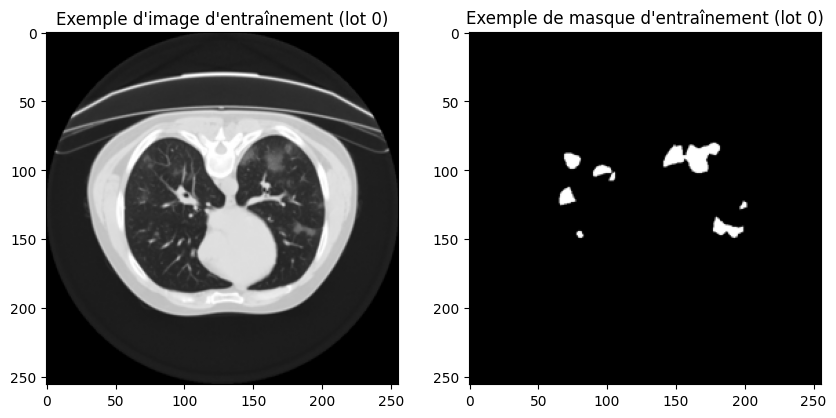

In [78]:
# --- Chemins des dossiers de données NORMALISÉES et DIVISÉES ---
dataset_path = "datas"
norm_frames_dir = os.path.join(dataset_path, "frames_norm")
norm_masks_dir = os.path.join(dataset_path, "masks_norm")
train_frames_folder = os.path.join(norm_frames_dir, "train")
val_frames_folder = os.path.join(norm_frames_dir, "val")
test_frames_folder = os.path.join(norm_frames_dir, "test")
train_masks_folder = os.path.join(norm_masks_dir, "train")
val_masks_folder = os.path.join(norm_masks_dir, "val")
test_masks_folder = os.path.join(norm_masks_dir, "test")

def get_filenames_from_folder(folder_path):
    """Récupère une liste de noms de fichiers .npy à partir d'un dossier."""
    return [f for f in os.listdir(folder_path) if f.endswith('.npy')]

train_image_filenames = get_filenames_from_folder(train_frames_folder)
val_image_filenames = get_filenames_from_folder(val_frames_folder)
test_image_filenames = get_filenames_from_folder(test_frames_folder)

BATCH_SIZE = 2

train_generator = CovidSegmentationDataGenerator(
    image_filenames=train_image_filenames,
    batch_size=BATCH_SIZE,
    frames_folder=train_frames_folder, # <--- DOSSier TRAIN FRAMES NORMALISÉES
    masks_folder=train_masks_folder,  # <--- DOSSier TRAIN MASKS NORMALISÉES
    shuffle=True
)

validation_generator = CovidSegmentationDataGenerator( # Générateur pour la validation
    image_filenames=val_image_filenames,
    batch_size=BATCH_SIZE,
    frames_folder=val_frames_folder,   # <--- DOSSier VALIDATION FRAMES NORMALISÉES
    masks_folder=val_masks_folder,     # <--- DOSSier VALIDATION MASKS NORMALISÉES
    shuffle=False # Pas de mélange pour la validation
)

test_generator = CovidSegmentationDataGenerator( # Générateur pour le test (peut être réutilisé pour la validation si vous n'avez pas d'ensemble de validation séparé)
    image_filenames=test_image_filenames,
    batch_size=BATCH_SIZE,
    frames_folder=test_frames_folder, # <--- DOSSier TEST FRAMES NORMALISÉES
    masks_folder=test_masks_folder,   # <--- DOSSier TEST MASKS NORMALISÉES
    shuffle=False # Pas de mélange pour le test
)


# --- Vérification des Data Generators ---
print(f"\nNombre de lots dans le générateur d'entraînement: {len(train_generator)}")
print(f"Nombre de lots dans le générateur de validation: {len(validation_generator)}")
print(f"Nombre de lots dans le générateur de test: {len(test_generator)}")

example_batch_images, example_batch_masks = train_generator[0]
print("\nShape d'un lot d'images d'entraînement:", example_batch_images.shape)
print("Shape d'un lot de masques d'entraînement:", example_batch_masks.shape)

example_image = example_batch_images[0]
example_mask = example_batch_masks[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(example_image), cmap='gray')
plt.title("Exemple d'image d'entraînement (lot 0)")

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(example_mask), cmap='gray')
plt.title("Exemple de masque d'entraînement (lot 0)")
plt.show()

In [81]:
def iou_metric(y_true, y_pred):
    """
    Calcule l'IoU (Intersection over Union) comme métrique de segmentation.
    """
    y_true = K.cast(y_true, K.floatx())  # Cast y_true to the default float type
    y_pred = K.cast(y_pred, K.floatx())  # Cast y_pred to the default float type
    intersection = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    union = K.sum(K.round(K.clip(y_true + y_pred,0, 1)))
    iou = intersection / (union + K.epsilon())
    return iou

def dice_coef_metric(y_true, y_pred):
    """
    Calcule le Dice Coefficient (Dice Score) comme métrique de segmentation.
    """
    y_true = K.cast(y_true, K.floatx()) # Cast y_true to the default float type
    y_pred = K.cast(y_pred, K.floatx()) # Cast y_pred to the default float type
    intersection = K.sum(K.flatten(y_true * y_pred)) # Intersection
    union = K.sum(K.flatten(y_true)) + K.sum(K.flatten(y_pred)) # Union
    dice = (2. * intersection + K.epsilon()) / (union + K.epsilon()) # Formule du Dice Coefficient
    return dice

model = build_unet_model(INPUT_SHAPE, NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics = ['Accuracy', iou_metric, dice_coef_metric] # <--- Ajout de dice_coef_metric à la liste des métriques
)
print("Modèle U-Net compilé avec succès !")

Modèle U-Net compilé avec succès !


In [88]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = 'unet_covid_segmentation_bw_best.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only = True,
    monitor = 'val_loss',
    mode='min',
    verbose = 1
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    #patience=10, # Augmentation de la patience à 10 epochs (plus robuste)
    verbose=1,
    restore_best_weights=True
)

EPOCHS = 5

history = model.fit(
    train_generator,
    validation_data=validation_generator, # <--- Utilisation du validation_generator
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

print("\nEntraînement du modèle U-Net terminé !")

Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Epoch 1/5
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape ap

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 144s 132ms/step - Accuracy: 0.9886 - dice_coef_metric: 0.4996 - iou_metric: 0.4406 - loss: 0.0224 - val_Accuracy: 0.9867 - val_dice_coef_metric: 0.4517 - val_iou_metric: 0.3229 - val_loss: 0.0267
Epoch 2/5
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256,

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 165s 151ms/step - Accuracy: 0.9888 - dice_coef_metric: 0.5255 - iou_metric: 0.4646 - loss: 0.0215 - val_Accuracy: 0.9893 - val_dice_coef_metric: 0.5935 - val_iou_metric: 0.5265 - val_loss: 0.0186
Epoch 3/5
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256,

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 180s 165ms/step - Accuracy: 0.9897 - dice_coef_metric: 0.6101 - iou_metric: 0.5346 - loss: 0.0181 - val_Accuracy: 0.9899 - val_dice_coef_metric: 0.6150 - val_iou_metric: 0.5163 - val_loss: 0.0175
Epoch 4/5
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256,

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 186s 170ms/step - Accuracy: 0.9903 - dice_coef_metric: 0.6130 - iou_metric: 0.5341 - loss: 0.0162 - val_Accuracy: 0.9899 - val_dice_coef_metric: 0.6122 - val_iou_metric: 0.5275 - val_loss: 0.0167
Epoch 5/5
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256,

In [89]:
print("\nÉvaluation du modèle sur l'ensemble de test:")
test_loss, test_accuracy, test_iou, test_dice_coef = model.evaluate(test_generator) # Utilisation du test_generator pour l'évaluation finale
print(f"Loss sur l'ensemble de test: {test_loss:.4f}")
print(f"Accuracy sur l'ensemble de test: {test_accuracy:.4f}")
print(f"IoU sur l'ensemble de test: {test_iou:.4f}")
print(f"Dice Coefficient sur l'ensemble de test: {test_dice_coef:.4f}")


Évaluation du modèle sur l'ensemble de test:
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_

## Now we test the model with predicting a mask and visualizing it  

Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape après np.load (image): (256, 256)
Shape après np.load (mask): (256, 256)
Shape après expand_dims (image): (256, 256, 1)
Shape après expand_dims (mask): (256, 256, 1)
Shape du batch d'images: (2, 256, 256, 1)
Shape du batch de masks: (2, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


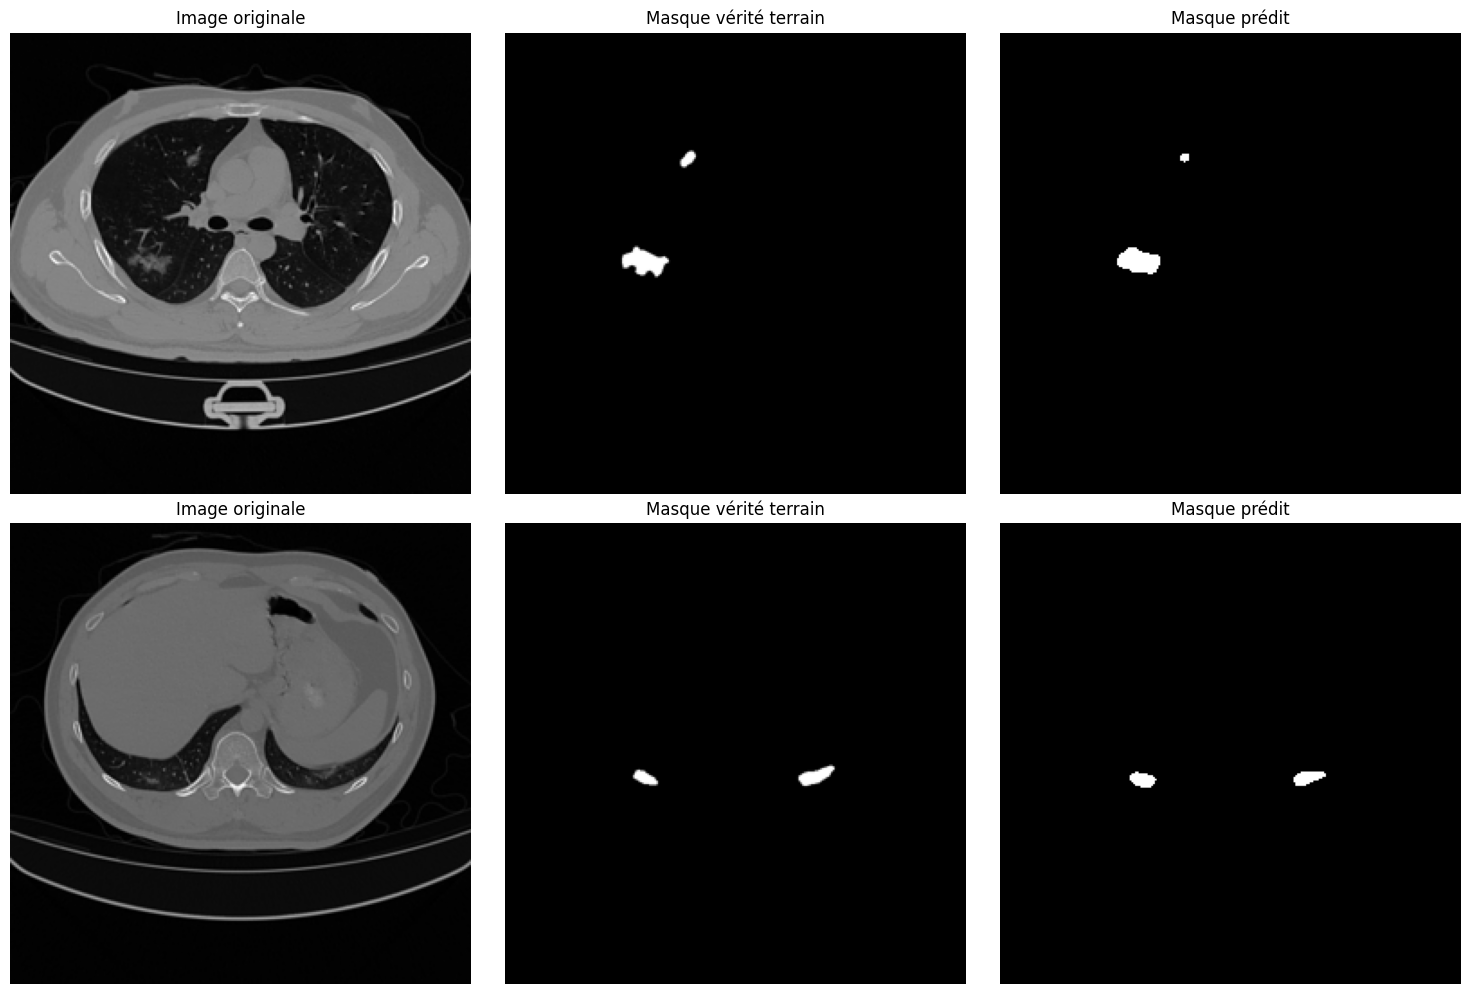

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# --- Cellule de visualisation des prédictions sur l'ensemble de test ---

def visualize_segmentation_results(generator, model, num_samples=3):
    """
    Visualise des exemples de résultats de segmentation du modèle.

    Args:
        generator: Data generator (par exemple, test_generator).
        model: Modèle Keras entraîné.
        num_samples: Nombre d'échantillons à visualiser.
    """

    # Obtenir un lot du générateur
    example_batch_images, example_batch_masks = generator[0] # Prendre le premier lot

    # Faire des prédictions sur le lot d'images
    predicted_masks = model.predict(example_batch_images)

    plt.figure(figsize=(15, 5 * num_samples)) # Ajuster la taille de la figure pour plusieurs exemples

    for i in range(num_samples):
        # Image originale
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(np.squeeze(example_batch_images[i]), cmap='gray') # Afficher en niveaux de gris
        plt.title("Image originale")
        plt.axis('off')

        # Masque vérité terrain
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(np.squeeze(example_batch_masks[i]), cmap='gray') # Afficher en niveaux de gris
        plt.title("Masque vérité terrain")
        plt.axis('off')

        # Masque prédit (appliquer un seuil si nécessaire pour binariser)
        plt.subplot(num_samples, 3, i * 3 + 3)
        predicted_mask_example = predicted_masks[i]
        predicted_mask_binary = (predicted_mask_example > 0.5).astype(np.float32) # Seuil à 0.5 pour binariser
        plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray') # Afficher en niveaux de gris
        plt.title("Masque prédit")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Utilisation de la fonction de visualisation avec le test_generator et votre modèle ---
visualize_segmentation_results(test_generator, model, num_samples=2) # Visualiser 2 exemples du test set (MODIFIED to num_samples=2)